<a href="https://colab.research.google.com/github/Elena-TKO/EEG-P300/blob/main/P300_evaluation_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import os
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy import signal
from scipy.interpolate import UnivariateSpline
from matplotlib.animation import FuncAnimation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Загружаем новые данные ээг

In [ ]:
#раскомментировать при первом запуске!
!unzip '/content/gdrive/MyDrive/My/EEG/Test' -d "/content/EEG"

Archive:  /content/gdrive/MyDrive/My/EEG/Test.zip
  inflating: /content/EEG/Test/Test1.txt  
  inflating: /content/EEG/Test/Test1_02.04.22..asc  
  inflating: /content/EEG/Test/Порядок.txt  


In [ ]:
names = os.listdir('/content/EEG/Test')
print(names)
persons = ([])
path_to = '/content/EEG/Test/'
for name in names:
  if "txt" in name and not('Порядок' in name):
    persons.append(name.split('.')[0])
print('Доступные испытуемые:' , persons)

['Test1_02.04.22..asc', 'Test1.txt', 'Порядок.txt']
Доступные испытуемые: ['Test1']


In [ ]:
#Choose person
choosen ='Test1'

for name in names:
  if choosen in name:
    if 'txt' in name:
      path_txt = path_to + name
    if 'asc' in name:
      path_asc = path_to + name
  if choosen in name and 'asc' in name:
    Path = path_to + name
print(path_txt, path_asc, Path)

/content/EEG/Test/Test1.txt /content/EEG/Test/Test1_02.04.22..asc /content/EEG/Test/Test1_02.04.22..asc


В названии колонок содержатся лишнии символы например пробелы

In [ ]:
columns = pd.read_table(Path ,sep = ',', engine = 'python', skiprows = 3, nrows = 0)

columns.rename(columns = {';Derivation names: Stim' : 'Stim'}, inplace = True)
for i in range(1, len(columns.columns)):
  c = columns.columns[i][1:]
  columns.rename(columns = {columns.columns[i]: c}, inplace = True)
columns.columns

Index(['Stim', 'Fp1A1', 'Fp2A2', 'FpzA2', 'F3A1', 'F4A2', 'FzA1', 'C3A1',
       'C4A2', 'CzA2', 'P3A1', 'P4A2', 'PzA1', 'O1A1', 'O2A2', 'OzA2', 'F7A1',
       'F8A2', 'T3A1', 'T4A2', 'T5A1', 'T6A2', 'Rs'],
      dtype='object')

Информация о записи

In [ ]:
order = np.genfromtxt(path_to+'Порядок.txt', delimiter = '\n')

In [ ]:
p = pd.read_table(path_asc , sep = ' ', engine='python', skiprows= 4, header = None)

In [ ]:
p.columns = columns.columns

In [ ]:
p.columns

Index(['Stim', 'Fp1A1', 'Fp2A2', 'FpzA2', 'F3A1', 'F4A2', 'FzA1', 'C3A1',
       'C4A2', 'CzA2', 'P3A1', 'P4A2', 'PzA1', 'O1A1', 'O2A2', 'OzA2', 'F7A1',
       'F8A2', 'T3A1', 'T4A2', 'T5A1', 'T6A2', 'Rs'],
      dtype='object')

Cz Pz Fz(шум от моргания выраженный)

In [ ]:
RS = p['Rs']

In [ ]:
EEG =p[[ 'Stim', 'CzA2', 'PzA1', 'FzA1', 'C3A1', 'C4A2' ]]

In [ ]:
file_parameters = open(path_txt)
parameters = file_parameters.readlines()[1:]
parameters = [el.replace('[', '') for el in parameters]
parameters = [el.replace(']', '') for el in parameters]
parameters = [el.split('=') for el in parameters]
parameters = [b.replace('\n','') for a,b in parameters]
start_time = [time for time in parameters[0]]
parameters[0] = parameters[0].replace(',','.')
parameters[0] = parameters[0].replace(';',',')
parameters = [p.replace(';','') for p in parameters]
parameters = [el.split(',') for el in parameters]
parameters[0].pop()
start_time = [a for a in parameters[0]]
fc = [int(a) for a in parameters[1]]
start_order = [int(a) for a in parameters[3]]
num_of_stim = [int(a) for a in parameters[4]]
mind_finger = [int(a) for a in parameters[5]]
print(start_time,'\n', fc,'\n', start_order,'\n',  num_of_stim, sum(num_of_stim), '\n',  mind_finger)

['3.34', '8.44', '14.44', '19.54', '25.53', '31.3'] 
 [1, 2, 1, 2, 1, 2] 
 [10, 310, 10, 310, 10, 310] 
 [300, 400, 300, 400, 300, 400] 2100 
 [3, 3, 5, 5, 3, 3]


In [ ]:
name_of_fingers = {1: 'Большой палец', 2: 'Указательный', 3: "Средний", 4: "Безымянный", 5: "Мизинец"}

In [ ]:
new_start_time = ([])
for tmee in start_time:
  print(tmee)
  tt = str(tmee).split('.')
  new_start_time.append(int(tt[0])*60 + int(tt[1]))

3.34
8.44
14.44
19.54
25.53
31.3


[214, 524, 884, 1194, 1553, 1863]

In [ ]:
def get_nearest_value(iterable = ([0,1,5,4,2,6]), value = 3):
  return min(enumerate(iterable), key=lambda x: abs(x[1] - value))[0]

Найдем где начинаются каждое из 5 стимуляций

In [ ]:
fd = 1000 # частота дискретизации
start_sec = EEG[EEG['Stim'] == 1].index # - секунды
idx_in = ([])
z = 0
for el in new_start_time:
  idx = get_nearest_value(start_sec.astype(int), el*1000)
  idx_in.append(start_sec[idx])
idx_end = ([])
a = 0
for i in range(len(start_sec)):
  if start_sec[i] in idx_in:
    idx_end.append(start_sec[i+num_of_stim[a]-1]+1)
    a += 1
idx_end[-1] = idx_end[-1]
#проверка
for i in range(len(idx_in)-1):
  if idx_end[i] > idx_in[i+1]:
    idx_end[i] = idx_in[i+1]-1
    print('Error', i)

In [ ]:

a = lambda x,y: (y-x) >= 1000
a2 = lambda x,y: (y-x) >= 500
aa = []
new_num_of_stim = ([])
for i in range(len(fc)):
  EE = EEG.loc[idx_in[i]:idx_end[i]]
  ss = EE[EE['Stim'] == 1].index
  new_num_of_stim.append(len(ss))
  el0=ss[0]
  if fc[i] == 1:
    for el in ss[1:]:
      aa.append([i,el0,a(el0, el)])
      el0=el
  else:
    for el in ss[1:]:
      aa.append([i,el0,a2(el0, el)])
      el0=el
for strr in aa:
  if strr[2] == False:
    print(str)

<class 'str'>
<class 'str'>


In [ ]:
new_order = np.array([])
for i in range(6):
  amk = order[start_order[i]:start_order[i]+new_num_of_stim[i]]
  new_order = np.append(new_order, amk)
new_order = new_order.astype(int)

In [ ]:
data = pd.DataFrame({})
need_order = np.array([])
for i in range(len(idx_in)):
  data1 = pd.DataFrame({
      'Stim': EEG['Stim'][idx_in[i]:idx_end[i]],
      'Finger': 0,
      'CzA2': EEG['CzA2'][idx_in[i]:idx_end[i]],
      'PzA1': EEG['PzA1'][idx_in[i]:idx_end[i]],
      'FzA1': EEG['FzA1'][idx_in[i]:idx_end[i]],
      'C3A1': EEG['C3A1'][idx_in[i]:idx_end[i]],
      'C4A2': EEG['C4A2'][idx_in[i]:idx_end[i]]
  })
  data = pd.concat([data,data1], axis = 0)
print(len(data.loc[(data.Stim == 1), 'Finger']), len(new_order))
data.loc[(data.Stim == 1), 'Finger'] = new_order
index_of_stim = data.loc[(data.Stim == 1)].index

2100 2100


In [ ]:
data_exp = data.copy(deep = True)
data_exp['Exp'] = 0
exp = 0
for i in range(len(idx_in)):
  exp+=1
  data_exp.loc[idx_in[i]:idx_end[i], 'Exp'] = exp

In [ ]:
def graf_norm(in_data, number, name = 'PzA1'):
  fig, subplots = plt.subplots(nrows = 1, sharey = True)
  x = range(1000)
  in_data = in_data.iloc[3000:4000]
  channel = (['CzA2', 'PzA1', 'FzA1', 'C3A1', 'C4A2' ])
  for ax in fig.axes:
    ax.grid(True)
    fig.set_size_inches(10, 5)
    for j in channel:
      ax.plot(x,
              in_data[j])

  #plt.savefig('destination_path.svg', format='svg', dpi=1000)
  plt.show()

In [ ]:
def coherent_av(data, chanels, idx,idx_end, num_of_stim, mind_finger, fc, n_25 = False, num = 25):
  #Функция когерентного усреднения ЭЭГ сигнала для выделения вызванного потенциала
  len_of_stim = []
  for el in fc:
    len_of_stim.append(int(1000/el))
  sum = 0
  a = -1
  error = []
  data_norm = 0
  new_data5 = ([])
  new_data = np.zeros(shape = (len(idx), 5, 1000))
  num_of_stim_to1finger = np.zeros(shape = (len(idx),5))
  idx_all = data[data['Stim'] == 1].index
  for j, i in enumerate(idx_all):
    fing = int(data['Finger'][i])
    if i in idx:
      a += 1
    if n_25 == True and  num_of_stim_to1finger[a, fing-1] >=num:
      continue
    d_np = data[chanels].loc[i:i+len_of_stim[a]-1].to_numpy()
    leng = len(data[chanels].loc[i:i+len_of_stim[a]-1].to_numpy())
    data_norm = (data_norm + np.average(d_np))/2
    if leng in [500,1000]:
        new_data[a, fing-1, :len_of_stim[a]] = new_data[a, fing-1,:len_of_stim[a]] + data[chanels].loc[i:i+len_of_stim[a]-1].to_numpy()
        if leng == 500 and j != len(idx_all)-1:
          new_data[a, fing-1, len_of_stim[a]:] = new_data[a, fing-1,len_of_stim[a]:] + data[chanels].loc[idx_all[j+1]:idx_all[j+1]+len_of_stim[a]-1].to_numpy()
        num_of_stim_to1finger[a, fing-1] += 1
    #else:
      #print(i, len(data[chanels][i:i+len_of_stim[a]].to_numpy()))
  for finger in range(5):
        for i in range(len(idx)):
          new_data[i,finger,:] = new_data[i,finger,:]/num_of_stim_to1finger[i,finger]
  return new_data, num_of_stim_to1finger


CzA2, CzA2_err = coherent_av(data, 'CzA2', idx_in,idx_end, num_of_stim, mind_finger, fc)
CzA2_2, CzA2_err_2 = coherent_av(data, 'CzA2', idx_in,idx_end, num_of_stim, mind_finger, fc, True, 25)

In [ ]:
def graf(in_data, number, name = 'PzA1'):
  fig, subplots = plt.subplots(nrows = len(in_data), sharey = True)

  x = range(1000)
  i = -1
  for ax in fig.axes:
      i+=1
      ax.grid(True)
      fig.set_size_inches(10, 20)
      ax.set_title('Эксперимент№ {}, Канал {}, f={} Гц \nВыбранный палец - {}'.format(i+1,
                                                                                      name,
                                                                                      fc[i],
                                                                                      name_of_fingers[mind_finger[i]]))
      color = ['darksalmon', 'bisque', 'plum', 'paleturquoise', 'lightblue']
      color[mind_finger[i]-1] = 'red'
      for j in range(5):
        ax.plot(x,
                -in_data[i,j,:],
                label = name_of_fingers[j+1]+'КУ: '+str(int(number[i,j])),
                color = color[j])

  plt.tight_layout(h_pad = 2)
  ax.legend(loc = 2)

  plt.savefig('destination_path.svg', format='svg', dpi=1000)
  plt.show()

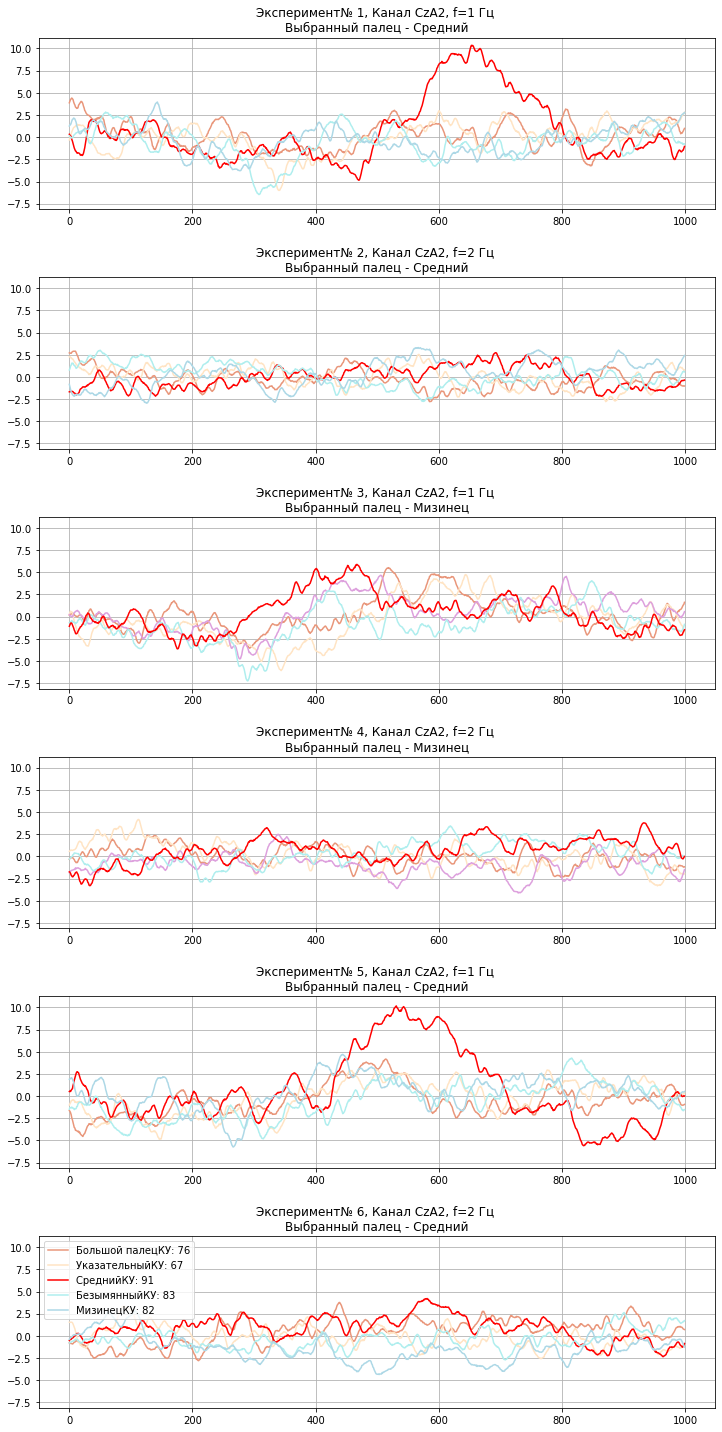

In [ ]:
graf(CzA2, CzA2_err, 'CzA2')

**Обработка дыхания**

In [ ]:
new_RS = pd.DataFrame({})
for i in range(len(idx_in)):
  rss = RS.loc[idx_in[i]:idx_end[i]]
  new_RS = pd.concat([new_RS,rss], axis = 0)
new_RS = RS.loc[data.index]
rs_data = new_RS.to_numpy(dtype = float)
rs_data = rs_data.ravel()
rs_idx = new_RS.index.values
rs_x = np.linspace(0, len(rs_data),  len(rs_data)).astype(int)

In [ ]:
def cut_len(x, y):
  y_new = np.array([])
  x_new = np.array([])
  y_new = np.append(y_new, y[0])
  x_new =np.append(x_new, x[0])
  for i in range(0, len(y)-1):
    if y[i] != y[i+1]:
      y_new = np.append(y_new, y[i])
      x_new = np.append(x_new, x[i])
  y_new = np.append(y_new, y[-1])
  x_new =np.append(x_new, x[-1])
  return x_new, y_new

def min_max(x,y):
  x_n = x
  y_n = y
  max = ([y_n[0]])
  idx_max = ([x_n[0]])
  min = ([y_n[0]])
  idx_min = ([x_n[0]])
  #ищем максимумы и минимумы
  a = 0
  b = 0
  inter = 300
  for i in range(1, len(y_n)-inter):
    #print(y_new[i+1] - y_new[i], y_new[i] - y_new[i-1])
    #также необходимо добавить проверку на мелкие колебания
    if (y_n[i+1] - y_n[i]) < 0 and (y_n[i-1] - y_n[i]) < 0 and ((y_n[i+inter] - y_n[i])*(y_n[i-inter]- y_n[i])) > 0 and (x_n[i]-idx_max[a])>inter and (x_n[i]-idx_min[b])>inter:
      max.append(y_n[i])
      idx_max.append(x_n[i])
      a += 1
    if (y_n[i+1] - y_n[i]) > 0 and (y_n[i-1] - y_n[i]) > 0 and ((y_n[i+inter] - y_n[i])*(y_n[i-inter]- y_n[i])) > 0 and (x_n[i]-idx_min[b])>inter and (x_n[i]-idx_max[a])>inter:
      min.append(y_n[i])
      idx_min.append(x_n[i])
      b +=1
  #print(idx_max)
  #print(idx_min)
  if idx_min[1] < idx_max[1] :
    min.pop(0)
    idx_min.pop(0)
  else:
    max.pop(0)
    idx_max.pop(0)
  #Добавляем последнюю точку
  if idx_max[-1] > idx_min[-1]:
    idx_min.append(x_n[-1]-1)
    min.append(y_n[-1])
  else:
    idx_max.append(x_n[-1]-1)
    max.append(y_n[-1])
  #Проверка на повторяющиеся экстремум
  to_del = ([])
  chmin = 0
  chmax = 0
  for i in x:
    if i in idx_min:
      chmin += 1
      chmax = 0
    if i in idx_max:
      chmax += 1
      chmin = 0
    if chmin == 2 or chmax == 2:
      to_del.append(i)
      print('Error', i)
      chmin = 0
      chmax = 0

  for i in idx_min:
    if i in to_del:
      min.remove(y[i])
      idx_min.remove(i)
  for i in idx_max:
    if i in to_del:
      max.remove(y[i])
      idx_max.remove(i)

  return ([min,idx_min, max, idx_max])

In [ ]:
rs_x_n, rs_y_n = cut_len(rs_x, rs_data)
f2 = interpolate.interp1d(rs_x_n, rs_y_n, kind = 'cubic')
y = f2(rs_x)
wn = 0.001
b, a = signal.butter(4, wn, 'lowpass')
filtedy = signal.filtfilt(b, a, y)

In [ ]:
extremums = min_max(rs_x, filtedy)
minimum,idx_min, maximum, idx_max = extremums

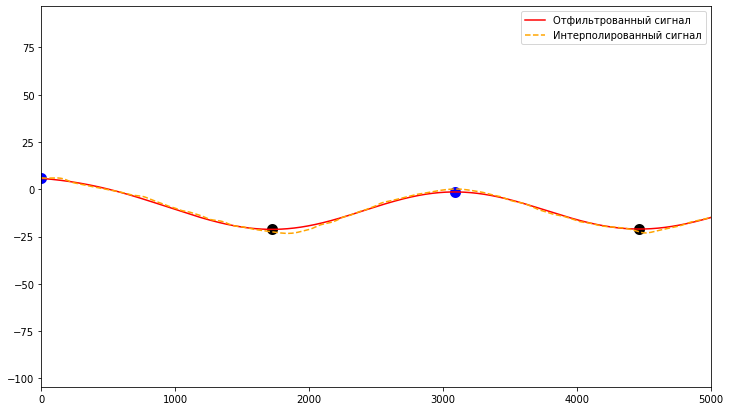

In [ ]:
def graf_of_breath(x, filt_y, interp_y, extr):
  plt.figure(figsize = (12, 7))
  plt.plot( x,filt_y, '-', color = 'red', label = 'Отфильтрованный сигнал')
  plt.plot( x, interp_y, '--', color = 'orange', label = "Интерполированный сигнал" )
  plt.scatter(extr[1], extr[0], color = 'black', linewidths = 5)
  #print(min,idx_min, max, idx_max)
  plt.scatter(extr[3], extr[2], color = 'blue', linewidths = 5)
  plt.scatter(1541850, 0)

  plt.legend()

  #plt.xlim([rs_x[-1]-10000, rs_x[-1]])
  #plt.xlim([403612-5000,403612+5000]) #интервал с точкой перегиба
  plt.xlim([0, 5000])

graf_of_breath(rs_x, filtedy, y, extremums)

In [ ]:
RS_new = pd.DataFrame({
    'RS': y ,
    'minimum': 0,
    'maximum': 0,
    'phase': 0,
}, index = rs_idx)
#data.loc[(data.Stim == 1), 'Finger'] = new_order

In [ ]:
RS_new['minimum'].loc[rs_idx[idx_min]] = 1
RS_new['maximum'].loc[rs_idx[idx_max]] = 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
def graf(in_data, name = 'PzA1'):
  fig, subplots = plt.subplots(nrows = len(in_data), sharey = True)
  i = -1
  x = range(1000)
  for ax in fig.axes:
    i += 1
    ax.grid(True)
    fig.set_size_inches(10, 20)
    ax.set_title('Эксперимент№ {}, Канал {}, f={} Гц \nВыбранный палец - {}'.format(i+1, name, fc[i], name_of_fingers[mind_finger[i]]))
    color = ['darksalmon', 'bisque', 'plum', 'paleturquoise', 'lightblue']
    color[mind_finger[i]-1] = 'red'
    for f in range(5):
      ax.plot(x, -in_data[i,f,:], label = name_of_fingers[f+1], color = color[f])
    plt.tight_layout(h_pad = 2)
    ax.legend(loc = 2)

  #plt.savefig('destination_path.svg', format='svg', dpi=1000)
  plt.show()

In [ ]:
first_interv = ([])
second_interv= ([])
#Задаем фазы дыхания считаем
if idx_max[0] == 0:
  a = idx_max
  b = idx_min
else:
  a = idx_min
  b = idx_max

for i in range(len(b)):
    first_interv = first_interv + rs_idx[a[i]:b[i]].tolist()
    if len(a) == len(b):
      if i+1 == len(b):
        break
    else:
      if i+1 >= len(a):
        break
    if b[i]<a[i] or a[i+1]<b[i]:
      print('Error Лишний экстремум', i, a[i])
      break
    second_interv = second_interv + rs_idx[b[i]:a[i+1]].tolist()

if idx_max[0] == 0:
  breath = first_interv
  exhalation = second_interv
else:
  breath = second_interv
  exhalation = first_interv


In [ ]:
data['phase'] = 0
data['phase'].loc[breath] = 2
data['phase'].loc[exhalation] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


***Теперь выделяем нужные потенциалы ***




In [ ]:
def f(a = ([0,1,5,4,2,6]), val = 3):
  return min((x for x in a if x > val), default=None)

In [ ]:
def get_nearest_value(iterable = ([0,1,5,4,2,6]), value = 3):
  return min(enumerate(iterable), key=lambda x: abs(x[1] - value))[0]

In [ ]:
idx_breath = data[(data['Stim'] == 1) & (data['phase'] == 2)].index
idx_breath = idx_breath.tolist()
idx_in_breath = ([])
for a in idx_in:
    idx_in_breath.append(f(idx_breath[:], a))

In [ ]:
dict_for_RS = {1: 'minimum', 2: 'maximum'}

'minimum'

In [ ]:
dict_for_m = {1: idx_min, 2: idx_max}

Когерентное усреднение синхронно с дыханием

In [ ]:
#Когерентное усреднение по фазе дыхания
def coherent_av_breath(what,rs_idx, data,chanels, idx,idx_end, num_of_stim, mind_finger, fc, n):
  len_of_stim = []
  for el in fc:
    len_of_stim.append(int(1000/el))
  sum = 0
  a = -1
  error = []
  breath = np.zeros(shape = (len(idx), 5, 1000))
  num_breath_to_finger = np.zeros(shape = (len(idx),5))
  idx_breath = data[(data['Stim'] == 1) & (data['phase'] == what)].index
  idx_breath = idx_breath.tolist()
  idx_in_breath = ([])
  for m in idx_in:
      idx_in_breath.append(f(idx_breath[:], m))

  for j, i in enumerate(idx_breath):
    fing = int(data['Finger'][i])
    if i in idx_in_breath:
        a += 1
    if num_breath_to_finger[a, fing-1] == n:
      continue
    leng = len(data[chanels].loc[i:i+len_of_stim[0]-1].to_numpy())
    if leng in [1000]:

          breath[a, fing-1, :] = breath[a, fing-1,:] + data[chanels].loc[i:i+len_of_stim[0]-1].to_numpy()
          num_breath_to_finger[a, fing-1] += 1

    #else:
      #print(i, len(data[chanels][i:i+len_of_stim[a]].to_numpy()))

  for finger in range(5):
        for i in range(len(idx)):
          breath[i,finger,:] = breath[i,finger,:]/num_breath_to_finger[i,finger]

  return breath, error



Функции отрисовки графиков

In [ ]:
#График для ВП с дыханием
def graf2(in_data, breath, exhalation, n_ex):
  fig, subplots = plt.subplots(nrows = len(in_data), sharex = True, sharey = True)
  i = -1
  x = range(1000)
  for ax in fig.axes:
    i += 1
    mf = mind_finger[i]-1
    ax.grid(True)
    fig.set_size_inches(10, 20)
    ax.set_title('Эксперимент№ {}, f={} \nВыбранный палец - {},т = {} '.format(i+1, fc[i], name_of_fingers[mind_finger[i]], n_ex))
    ax.plot(x, -in_data[i,mf,:], label = 'Начальный ВП')
    ax.plot(x, -breath[i,mf,:], label = "ВП на вдохе")
    ax.plot(x, -exhalation[i,mf,:], label = "ВП на выдохе")
    ax.axvline(x = 300, color = 'black')
    ax.legend()

  #plt.savefig('destination_path2.svg', format='svg', dpi=1000)
  plt.show()